<a href="https://colab.research.google.com/github/LACDR-CDS/SCDR_RNAseq/blob/main/GATA4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transcriptional impact of GATA4 mutation on human cardiomyocyte differentiation

### Research Question
Which pathways are altered in GATA4 mutant cardiomyocyte differentiation compared to wildtype?

### Background  
Mutations in **GATA4**, a key transcription factor in heart development, are linked to **congenital heart defects** and **cardiomyopathy**.  
To investigate the molecular basis, you will compare **isogenic wildtype** and **GATA4-G296S mutant** cells at different stages of cardiomyocyte differentiation using RNA-seq.  

Previous studies found that:  
- GATA4 normally co-occupies cardiac enhancers with **TBX5**, another cardiac transcription factor.  
- The **G296S mutation** disrupts TBX5 recruitment, especially at **super-enhancers**.  
- This leads to:  
  - **Downregulation of cardiac programs** (e.g., contraction, calcium handling, septation).  
  - **Aberrant activation of endothelial/endocardial pathways**.  

### Objectives
1. Explore whether GATA4 mutation alters global gene expression patterns (PCA).  
2. Identify differentially expressed genes (DEGs) between mutant and WT at each stage.  
3. Visualize DEGs with volcano plots and heatmaps.  
4. Perform GO enrichment to determine affected biological pathways.  
5. Interpret whether the mutation leads to loss of cardiomyocyte identity and/or gain of non-cardiac programs.  


In [23]:
#Install packages
%pip install scanpy
%pip install PyDESeq2
%pip install gseapy

## Set up libraries and download data

In [24]:
# Imports
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import gseapy
import os
import warnings
warnings.filterwarnings("ignore")

In [25]:
#Make data directory if it does not exist
os.makedirs("data", exist_ok=True)

#Download datasets
!wget https://raw.githubusercontent.com/LACDR-CDS/SCDR_RNAseq/refs/heads/main/data/dataset2.txt -O data/dataset2.txt
!wget https://raw.githubusercontent.com/LACDR-CDS/SCDR_RNAseq/refs/heads/main/data/dataset2_metadata.csv -O data/dataset2_metadata.csv

--2025-09-23 18:12:14--  https://raw.githubusercontent.com/LACDR-CDS/SCDR_RNAseq/refs/heads/main/data/dataset2.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1741783 (1.7M) [text/plain]
Saving to: ‘data/dataset2.txt’

data/dataset2.txt   100%[===================>]   1.66M  --.-KB/s    in 0.04s   

2025-09-23 18:12:15 (43.9 MB/s) - ‘data/dataset2.txt’ saved [1741783/1741783]

--2025-09-23 18:12:15--  https://raw.githubusercontent.com/LACDR-CDS/SCDR_RNAseq/refs/heads/main/data/dataset2_metadata.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response

## Load data

In [26]:
counts = pd.read_csv("data/dataset2.txt", sep="\t", index_col=0)
counts.head()

,day7_rep1_wt,day7_rep2_wt,day7_rep1_mut,day7_rep2_mut,day15_rep1_wt,day15_rep2_wt,day15_rep1_mut,day15_rep2_mut,day32_rep1_wt,day32_rep2_wt,day32_rep1_mut,day32_rep2_mut
DDX11L1,0,0,0,0,0,1,0,0,0,0,0,0
WASH7P,12,13,17,12,10,12,6,14,9,15,6,11
MIR6859-1,0,0,0,0,0,0,0,0,0,1,0,0
MIR1302-2HG,0,0,0,0,0,0,0,0,0,0,0,0
MIR1302-2,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
meta = pd.read_csv("data/dataset2_metadata.csv")
meta = meta.set_index("sample_id")
meta.head()

,day,replicate,stage,cell line,condition
sample_id,,,,,
day7_rep1_wt,7,1,cardiac progenitor,hiPSC,isogenic wildtype
day7_rep2_wt,7,2,cardiac progenitor,hiPSC,isogenic wildtype
day7_rep1_mut,7,1,cardiac progenitor,hiPSC,missense mutation
day7_rep2_mut,7,2,cardiac progenitor,hiPSC,missense mutation
day15_rep1_wt,15,1,cardiomyocyte,hiPSC,isogenic wildtype


Filtering

## Filtering

In [28]:
counts = counts[counts.sum(axis=1) >= 10]

## Normalization

In [29]:
cpm = (counts / counts.sum(axis=0)) * 1e6
log_cpm = np.log2(cpm + 1)

## PCA

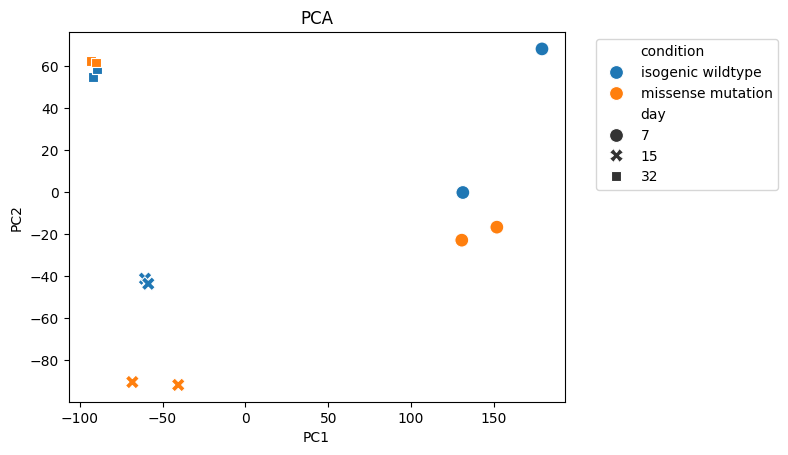

In [30]:
# QUESTION: What separates samples the most: condition (mutant vs WT) or day (7, 15, 32)?
scaled = StandardScaler().fit_transform(log_cpm.T)
pc = PCA(n_components=2).fit_transform(scaled)

pc_df = pd.DataFrame({"PC1": pc[:,0], "PC2": pc[:,1],
                      "condition": meta["condition"], "day": meta["day"]})

sns.scatterplot(data=pc_df, x="PC1", y="PC2", hue="condition", style="day", s=100)
plt.title("PCA")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


## Differential Gene Expression

In [21]:
day = 7   # <-- change to see the other days

meta_day = meta[meta["day"] == day]
counts_day = counts[meta_day.index]

# Run DESeq2
dds = DeseqDataSet(counts=counts_day.T, metadata=meta_day, design_factors="condition")
dds.deseq2()
stats = DeseqStats(dds, contrast=("condition","missense mutation","isogenic wildtype"))
stats.summary()
res = stats.results_df.sort_values("padj")

# QUESTION: How many genes are significant (padj < 0.05)?
print((res.padj < 0.05).sum(), "significant genes")

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 33.14 seconds.

Fitting dispersion trend curve...
... done in 1.70 seconds.

Fitting MAP dispersions...
... done in 49.41 seconds.

Fitting LFCs...
... done in 24.18 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 7.21 seconds.



Log2 fold change & Wald test p-value: condition missense mutation vs isogenic wildtype
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
WASH7P           13.431601        0.153553  0.780321  0.196783  0.843998   
LOC124900384      2.956069        0.424673  1.434103  0.296124  0.767135   
LOC729737       135.281214       -0.031587  0.476024 -0.066355  0.947095   
DDX11L17          3.214263        0.158142  1.293477  0.122261  0.902692   
LOC100996442      6.752326        0.711542  1.343225  0.529727  0.596302   
...                    ...             ...       ...       ...       ...   
ND4           27346.126224        0.977647  2.678465  0.365003  0.715109   
ND5           20331.759876        0.736230  3.106380  0.237006  0.812652   
ND6            1601.470949        1.524557  2.734839  0.557458  0.577215   
CYTB          24055.294149        0.898022  3.116728  0.288130  0.773247   
TRNP             29.563766        1.364562  2.074080  0.657912  0.510595   



## Volcano plot

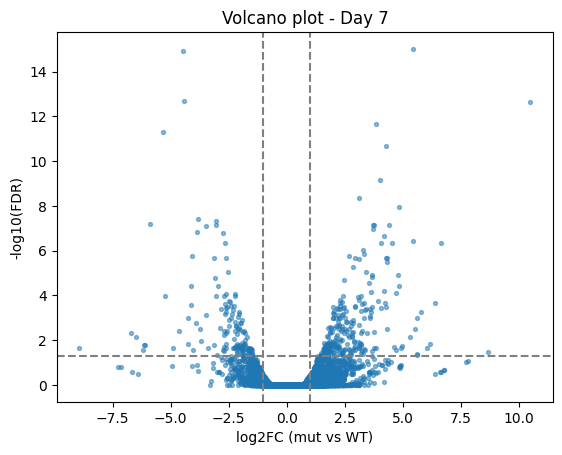

In [22]:
# QUESTION: Are more genes up in mutant or WT? Are the effects strong (large log2FC) or subtle?
plt.scatter(res.log2FoldChange, -np.log10(res.padj), s=8, alpha=0.5)
plt.axhline(-np.log10(0.05), ls="--", color="grey")
plt.axvline(1, ls="--", color="grey"); plt.axvline(-1, ls="--", color="grey")
plt.xlabel("log2FC (mut vs WT)")
plt.ylabel("-log10(FDR)")
plt.title(f"Volcano plot - Day {day}")
plt.show()

## Heatmap

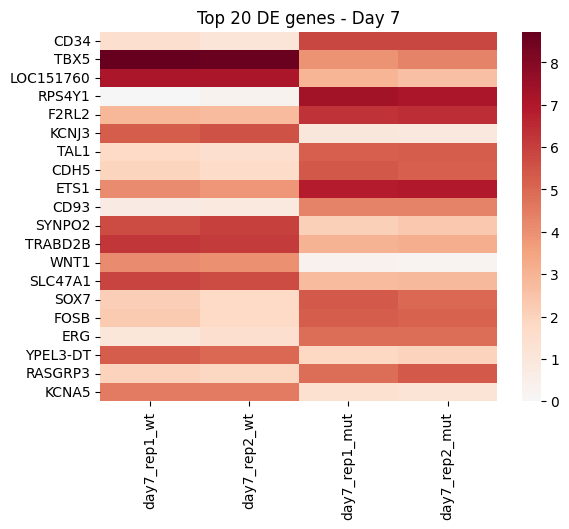

In [33]:
cpm_day = (counts_day / counts_day.sum(axis=0)) * 1e6
log_cpm_day = np.log2(cpm_day + 1)
top = res.head(20).index

# QUESTION: Do the top DE genes cluster mutant and WT samples apart? Write down 5 genes that are upregulated and downregulated in mutant samples, can you find out their function in literature?
sns.heatmap(log_cpm_day.loc[top], cmap="RdBu_r", center=0)
plt.title(f"Top 20 DE genes - Day {day}")
plt.show()

## GO enrichment

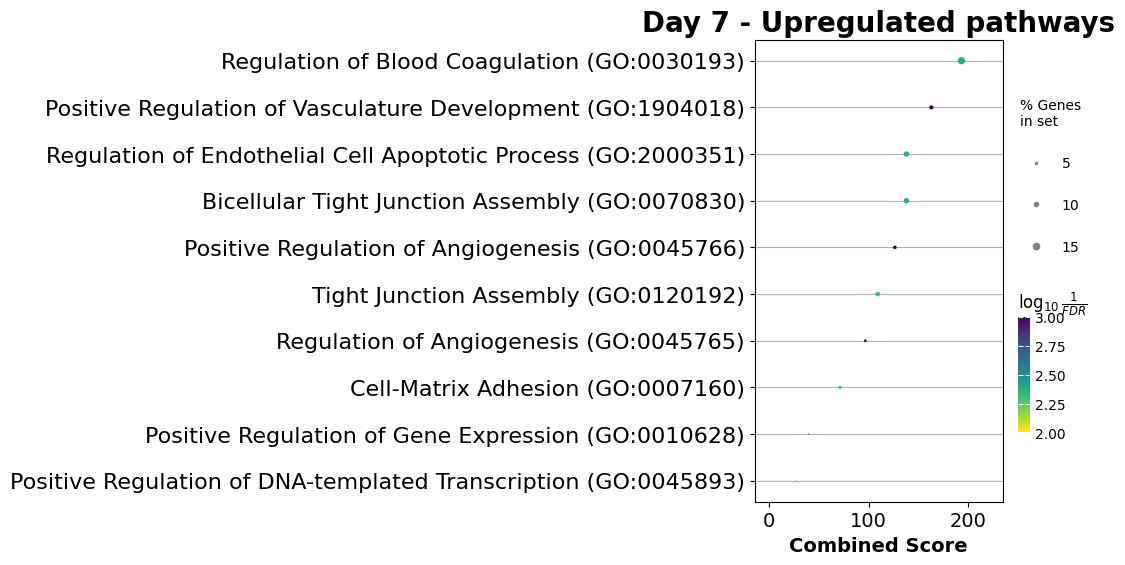

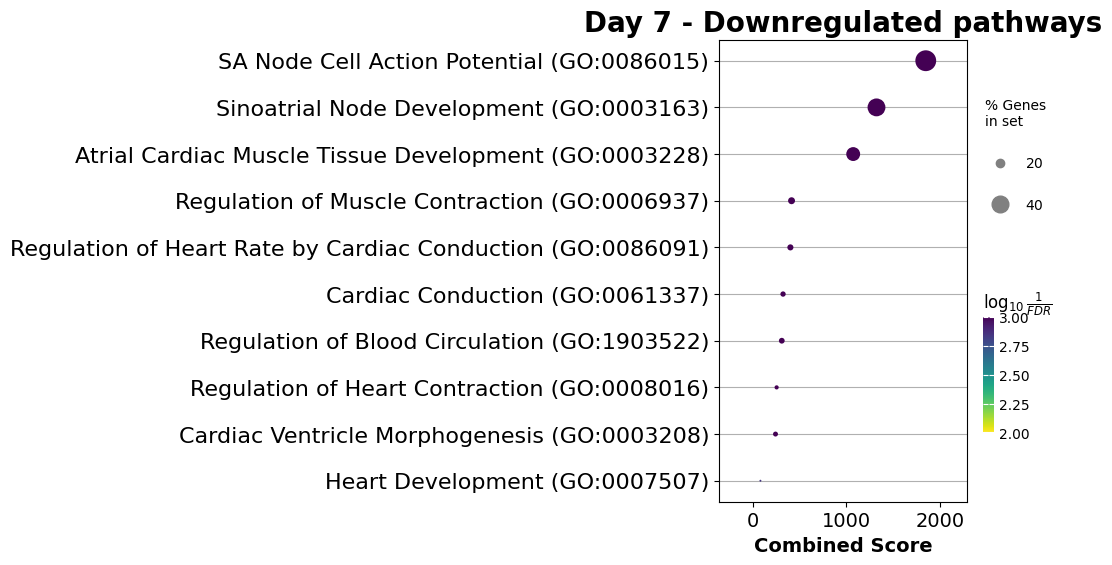

In [32]:
up   = res[(res.log2FoldChange > 1) & (res.padj < 0.05)]
down = res[(res.log2FoldChange < -1) & (res.padj < 0.05)]

# QUESTION: Which biological processes are downregulated in mutant vs WT at this day? Can you find scientific evidence in literature that these processes are regulated by GATA4?
enr_up = gseapy.enrichr(up.index.tolist(),
                        gene_sets=["GO_Biological_Process_2025"],
                        organism="Human", cutoff=0.1)
gseapy.plot.dotplot(enr_up.res2d, title=f"Day {day} - Upregulated pathways", top_term=10)
plt.show()

enr_down = gseapy.enrichr(down.index.tolist(),
                          gene_sets=["GO_Biological_Process_2025"],
                          organism="Human", cutoff=0.1)
gseapy.plot.dotplot(enr_down.res2d, title=f"Day {day} - Downregulated pathways", top_term=10)
plt.show()